In [1]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, roc_curve,
                             precision_recall_fscore_support, accuracy_score)
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline

# Imbalanced handling
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore") 


In [2]:
# Visualization settings
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,6)

In [3]:

DATA_PATH = "/media/kibria/624309e6-cae1-4eca-a603-4ebc61fc0d9b/data/archive (2)/covid-19_vaccine_tweets_with_sentiment.csv"

# Try with Windows-1252 first
df = pd.read_csv(DATA_PATH, encoding="cp1252")  # or encoding="ISO-8859-1"
print('Raw data shape:', df.shape)
print(df.columns)

Raw data shape: (6000, 3)
Index(['tweet_id', 'label', 'tweet_text'], dtype='object')


In [4]:
df.head()

,tweet_id,label,tweet_text
0,1.360342e+18,1,"4,000 a day dying from the so called Covid-19 ..."
1,1.382896e+18,2,Pranam message for today manifested in Dhyan b...
2,1.375673e+18,2,Hyderabad-based ?@BharatBiotech? has sought fu...
3,1.381311e+18,1,"Confirmation that Chinese #vaccines ""don’t hav..."
4,1.362166e+18,3,"Lab studies suggest #Pfizer, #Moderna vaccines..."


In [5]:
if 'text' not in df.columns:
    # try alternatives
    for alt in ['tweet', 'content', 'text_clean', 'tweet_text']:
        if alt in df.columns:
            df.rename(columns={alt: 'text'}, inplace=True)
            break

if 'sentiment' not in df.columns:
    # try label alternatives
    for alt in ['label', 'sentiment_label', 'sentiment_value']:
        if alt in df.columns:
            df.rename(columns={alt: 'sentiment'}, inplace=True)
            break


In [6]:
# Drop missing
df = df.dropna(subset=['text','sentiment']).reset_index(drop=True)

In [7]:
df.head()

,tweet_id,sentiment,text
0,1.360342e+18,1,"4,000 a day dying from the so called Covid-19 ..."
1,1.382896e+18,2,Pranam message for today manifested in Dhyan b...
2,1.375673e+18,2,Hyderabad-based ?@BharatBiotech? has sought fu...
3,1.381311e+18,1,"Confirmation that Chinese #vaccines ""don’t hav..."
4,1.362166e+18,3,"Lab studies suggest #Pfizer, #Moderna vaccines..."


In [8]:
# Basic class balance
class_counts = df['sentiment'].value_counts()
print('\nClass distribution:')
print(class_counts)


Class distribution:
sentiment
2    3680
3    1900
1     420
Name: count, dtype: int64


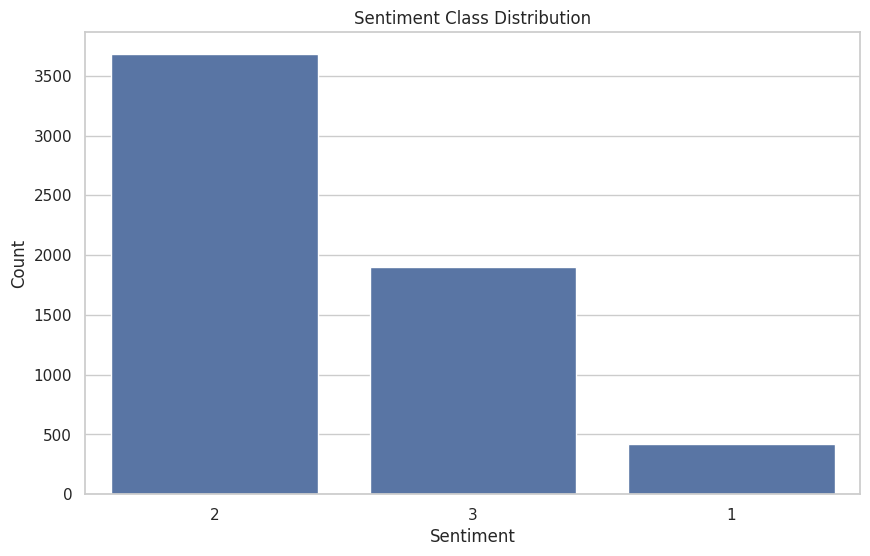

In [9]:
# Plot class distribution
plt.figure()
sns.barplot(x=class_counts.index.astype(str), y=class_counts.values)
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


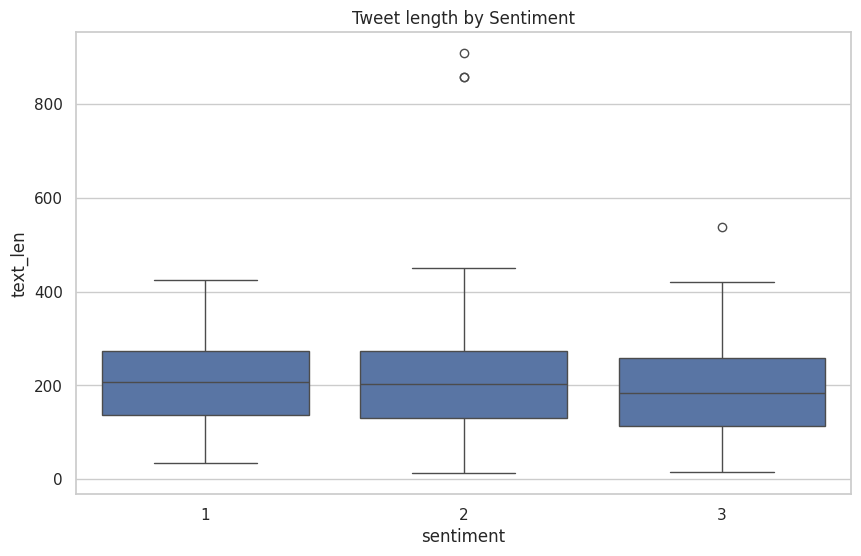

In [10]:

# Tweet length distribution by sentiment
df['text_len'] = df['text'].apply(len)
plt.figure()
sns.boxplot(x='sentiment', y='text_len', data=df)
plt.title('Tweet length by Sentiment')
plt.show()

In [11]:
# Top hashtags and top words (quick)
hashtag_re = re.compile(r"#\w+")

all_hashtags = df['text'].str.findall(hashtag_re).explode().dropna().str.lower()
print('\nTop 15 hashtags:')
print(all_hashtags.value_counts().head(15))


Top 15 hashtags:
text
#moderna              2144
#covid19              1354
#covaxin              1289
#sputnikv             1081
#vaccine               918
#pfizerbiontech        716
#pfizer                620
#covidvaccine          566
#oxfordastrazeneca     345
#astrazeneca           341
#sinopharm             334
#coronavirus           330
#sinovac               328
#covid                 327
#covid19vaccine        287
Name: count, dtype: int64


In [12]:
# Tokenize and simple word frequency
nltk.download('punkt')

tokenizer = TweetTokenizer(reduce_len=True)
all_tokens = df['text'].apply(lambda t: tokenizer.tokenize(t.lower()))
stop_words = set(stopwords.words('english')) if 'stopwords' in nltk.corpus.__dict__ else set()

# build frequency
freq = Counter()
for tokens in all_tokens:
    for t in tokens:
        if t.isalpha() and t not in stop_words:
            freq[t] += 1

most_common = freq.most_common(30)
print('\nMost common words (top 30):')
print(most_common)


[nltk_data] Downloading package punkt to /home/kibria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Most common words (top 30):
[('the', 5210), ('to', 3351), ('of', 3286), ('and', 2364), ('in', 2297), ('vaccine', 2180), ('a', 1765), ('is', 1740), ('for', 1628), ('i', 1381), ('my', 1007), ('on', 966), ('it', 958), ('with', 779), ('you', 766), ('no', 761), ('this', 752), ('first', 729), ('covid', 716), ('that', 713), ('are', 708), ('dose', 681), ('be', 661), ('have', 642), ('at', 629), ('from', 598), ('has', 588), ('by', 582), ('as', 580), ('not', 569)]


In [13]:


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

url_re = re.compile(r'https?://\S+|www\.\S+')
user_re = re.compile(r'@\w+')
non_alphanum_re = re.compile(r'[^a-zA-Z\s]')


def clean_text(text):
    text = str(text)
    text = url_re.sub('', text)
    text = user_re.sub('', text)
    text = text.replace('\n', ' ')
    text = non_alphanum_re.sub(' ', text)
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

# Apply cleaning (can take time)
print('\nCleaning texts (this may take a minute)...')
df['clean_text'] = df['text'].apply(clean_text)

print('\nExample cleaned text:')
print(df[['text','clean_text']].head())



Cleaning texts (this may take a minute)...


[nltk_data] Downloading package stopwords to /home/kibria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kibria/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/kibria/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Example cleaned text:
                                                text  \
0  4,000 a day dying from the so called Covid-19 ...   
1  Pranam message for today manifested in Dhyan b...   
2  Hyderabad-based ?@BharatBiotech? has sought fu...   
3  Confirmation that Chinese #vaccines "don’t hav...   
4  Lab studies suggest #Pfizer, #Moderna vaccines...   

                                          clean_text  
0  day dying called covid vaccine report vaccine ...  
1  pranam message today manifested dhyan truth lo...  
2  hyderabad based sought fund government ramp pr...  
3  confirmation chinese vaccine high protection r...  
4  lab study suggest pfizer moderna vaccine prote...  


In [14]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
X_tfidf = vectorizer.fit_transform(df['clean_text'])
print('\nTF-IDF matrix shape:', X_tfidf.shape)

# 5.2 Lexicon/Rule-based features: VADER polarity scores
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

vader_scores = df['text'].apply(lambda t: sia.polarity_scores(str(t)))
vader_df = pd.DataFrame(list(vader_scores))
# concatenate

# 5.3 Simple length/hashtag features
X_meta = pd.DataFrame({
    'text_len': df['text_len'],
    'num_hashtags': df['text'].str.count('#'),
    'num_mentions': df['text'].str.count('@'),
})



TF-IDF matrix shape: (6000, 20000)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/kibria/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
from scipy.sparse import hstack
X_final = hstack([X_tfidf, np.array(vader_df), np.array(X_meta)])


if df['sentiment'].dtype == object:
    y = df['sentiment'].astype('category').cat.codes
    label_mapping = dict(enumerate(df['sentiment'].astype('category').cat.categories))
else:
    y = df['sentiment']
    label_mapping = None

print('\nLabel mapping (if applicable):', label_mapping)


Label mapping (if applicable): None


In [16]:
k = 5000
selector = SelectKBest(chi2, k=k)
# apply selector to tfidf part (first vectorizer feature count)
num_tfidf_features = X_tfidf.shape[1]
X_tfidf_selected = selector.fit_transform(X_tfidf, y)
print(f"Selected TF-IDF shape: {X_tfidf_selected.shape}")

Selected TF-IDF shape: (6000, 5000)


In [17]:
# Rebuild X with selected tfidf + meta + vader
X_selected = hstack([X_tfidf_selected, np.array(vader_df), np.array(X_meta)])

# ---------------------------
# 7. Train-test split and balancing
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)
print('\nTrain shape:', X_train.shape, 'Test shape:', X_test.shape)

# If classes are imbalanced, apply SMOTE after converting to dense for non-sparse-safe algorithms
print('\nClass distribution in train:')
print(pd.Series(y_train).value_counts())



Train shape: (4800, 5007) Test shape: (1200, 5007)

Class distribution in train:
sentiment
2    2944
3    1520
1     336
Name: count, dtype: int64


In [18]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'LinearSVC': LinearSVC(max_iter=2000),
    'RandomForest': RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
}

In [19]:
results = {}
for name, model in models.items():
    print(f'\nTraining {name}...')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'{name} accuracy: {acc:.4f}')
    print(classification_report(y_test, y_pred))
    results[name] = {'model': model, 'acc': acc}



Training LogisticRegression...
LogisticRegression accuracy: 0.7350
              precision    recall  f1-score   support

           1       0.27      0.04      0.06        84
           2       0.73      0.92      0.82       736
           3       0.76      0.53      0.63       380

    accuracy                           0.73      1200
   macro avg       0.59      0.50      0.50      1200
weighted avg       0.71      0.73      0.70      1200


Training LinearSVC...
LinearSVC accuracy: 0.7017
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        84
           2       0.68      0.96      0.80       736
           3       0.81      0.35      0.49       380

    accuracy                           0.70      1200
   macro avg       0.50      0.44      0.43      1200
weighted avg       0.68      0.70      0.65      1200


Training RandomForest...
RandomForest accuracy: 0.7242
              precision    recall  f1-score   support

         

In [20]:
param_grid = {'C': [0.01, 0.1, 1, 10]}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
clf = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1)
clf.fit(X_train, y_train)
print('\nBest params for LogisticRegression:', clf.best_params_)
print('CV best score:', clf.best_score_)

# Evaluate best estimator
best_lr = clf.best_estimator_
y_pred = best_lr.predict(X_test)
print('\nClassification report for best LogisticRegression:')
print(classification_report(y_test, y_pred))


/home/kibria/dl_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kibria/dl_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi


Best params for LogisticRegression: {'C': 10}
CV best score: 0.7057680108105204

Classification report for best LogisticRegression:
              precision    recall  f1-score   support

           1       0.38      0.04      0.07        84
           2       0.75      0.90      0.82       736
           3       0.72      0.58      0.64       380

    accuracy                           0.74      1200
   macro avg       0.62      0.51      0.51      1200
weighted avg       0.71      0.74      0.71      1200



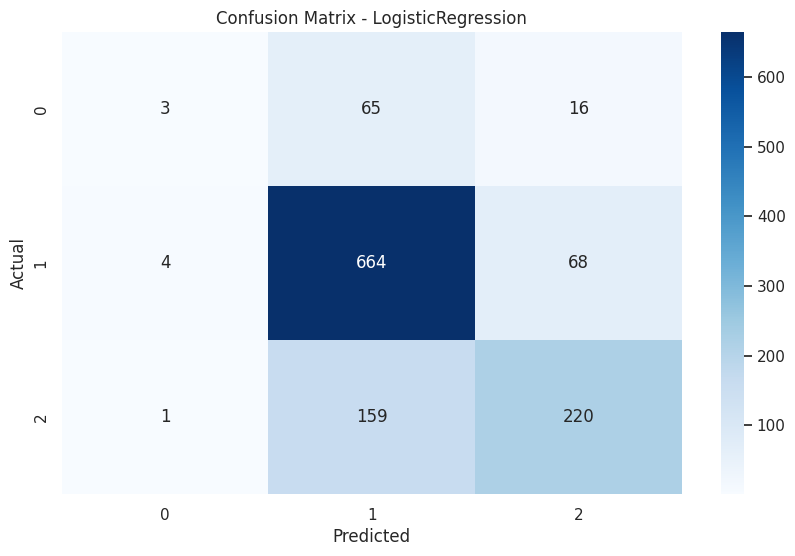

In [21]:
# Confusion matrix for best LR
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LogisticRegression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
len(np.unique(y))

3

Multiclass ROC AUC (OvR): 0.8315948174288806


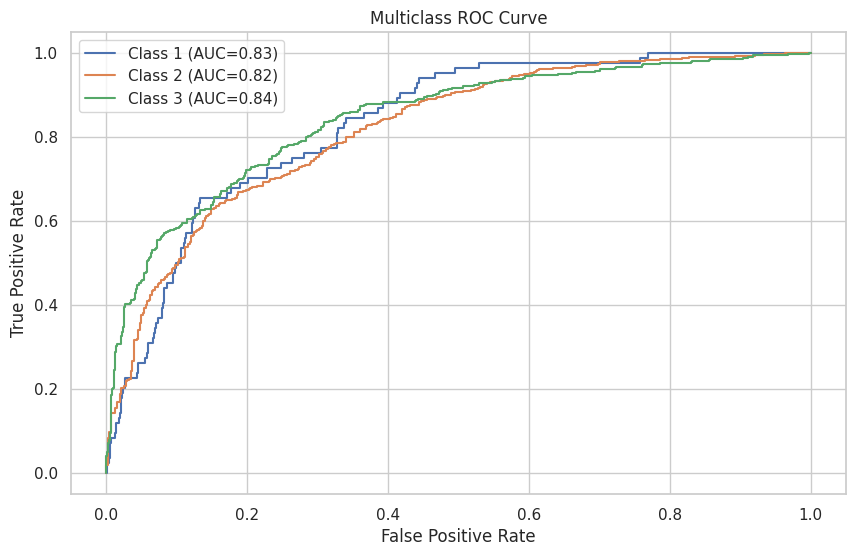

In [23]:
# Binarize labels for multiclass
from sklearn.preprocessing import label_binarize
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_lr.predict_proba(X_test)

# Compute AUC for each class
auc = roc_auc_score(y_test_bin, y_score, multi_class='ovr')
print("Multiclass ROC AUC (OvR):", auc)

# Plot ROC for each class
plt.figure()
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC={roc_auc_score(y_test_bin[:, i], y_score[:, i]):.2f})')

plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [24]:
# Example hypothesis: "Mean tweet length differs between positive and negative tweets"
from scipy.stats import ttest_ind, chi2_contingency

# Prepare groups (only if binary or picking two labels)
unique_labels = list(pd.Series(y).unique())
if len(unique_labels) >= 2:
    a_label, b_label = unique_labels[0], unique_labels[1]
    a_lens = df.loc[y == a_label, 'text_len']
    b_lens = df.loc[y == b_label, 'text_len']
    tstat, pval = ttest_ind(a_lens, b_lens, equal_var=False)
    print(f"T-test between label {a_label} and {b_label}: t={tstat:.3f}, p={pval:.3e}")

# Chi-square: are hashtags associated with sentiment? Build contingency table for presence of hashtags
hashtag_presence = (df['num_hashtags'] > 0).astype(int) if 'num_hashtags' in df.columns else (df['text'].str.contains('#').astype(int))
cont_table = pd.crosstab(hashtag_presence, y)
chi2, p, dof, ex = chi2_contingency(cont_table)
print('Chi-square test for hashtag presence vs sentiment: chi2=%.3f p=%.3e' % (chi2, p))

T-test between label 1 and 2: t=1.273, p=2.036e-01
Chi-square test for hashtag presence vs sentiment: chi2=0.000 p=1.000e+00


In [25]:
# ---------------------------
if hasattr(best_lr, 'coef_'):
    feature_names = vectorizer.get_feature_names_out()
    k_show = 20
    for i, class_coef in enumerate(best_lr.coef_ if best_lr.coef_.ndim > 1 else [best_lr.coef_]):
        top_pos = np.argsort(class_coef)[-k_show:][::-1]
        top_neg = np.argsort(class_coef)[:k_show]
        print(f"\nTop positive features for class {i}:")
        print([feature_names[idx] for idx in top_pos if idx < len(feature_names)])


Top positive features for class 0:
['covaxin astrazeneca', 'covaxin congressmuktbharat', 'biotech aiims', 'another batch', 'africa', 'also set', 'also take', 'also want', 'brazilian partner', 'covaxin covidvaccination', 'adenovirus', 'covaxin arrive', 'coronavirusvaccination infant', 'covaxin delhi', 'covid jab', 'covaxin covishieldindia', 'covid spring', 'craft', 'correct miss', 'covaxin since']

Top positive features for class 1:
['clot receiving', 'craig', 'covaxin allow', 'corrupt', 'countering covid', 'covid largestvaccinedrive', 'count found', 'canada get', 'covaxin faug', 'covid reveals', 'coronavirusvaccine pfizervaccine', 'arriba venezuela', 'announced today', 'covid ncovid', 'covid country', 'country ie', 'covid columbus', 'coronavac donated', 'covid click', 'covidends']

Top positive features for class 2:
['covidvaccination cowin', 'china coronavaccine', 'convince', 'controversial possibly', 'buying sputnikv', 'corona ji', 'covid thankyou', 'contributing', 'cheer', 'copd fo